## Column Definitions

Data comes from: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

1. age: (numeric)
2. job: type of job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "selfemployed", "services", "student", "technician", "unemployed", "unknown")
3. marital: marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
4. education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")
5. default: has credit in default? (categorical: "no", "yes", "unknown")
6. housing: has housing loan? (categorical: "no","yes","unknown")
7. loan: has personal loan? (categorical: "no", "yes", "unknown")

#### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: "cellular", "telephone") 
9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. day_of_week: last contact day of the week (categorical: "mon", "tue", "wed", "thu", "fri")
11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

#### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)     
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: "yes","no")

## Import Libraries

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import eli5
import matplotlib.pyplot as plt
%matplotlib inline

from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Read data and drop "duration" column since this column is collected after label is observed.
df = pd.read_csv(r'C:/Users/mzhang40/data/bank_marketing/bank-additional-full.csv', delimiter=';')
df = df.drop(['duration'], axis=1)

# Create dummy variables and train/test split
df_dummy = pd.concat([pd.get_dummies(df.drop(['y'], axis=1)), df.y], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_dummy.drop(['y'], axis=1), df_dummy.y, test_size=0.3, random_state=1)

## Fit Models

In [18]:
seed = 1

rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(random_state=seed)
gb_model.fit(X_train, y_train)

tree_model = DecisionTreeClassifier(random_state=seed)
tree_model.fit(X_train, y_train)

logit_model = LogisticRegression(max_iter=1000, random_state=seed)
logit_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1)

## Feature Distributions

This section visually examines how the distribution of one class differ from that of another class. If any feature demonstrates  obviously different distributions between two classes then this feature might have strong predictive power.

Economic indicators: Employee Variable Rate, Consumer Price Index, Consumer Confidence Index, Europe Inter-Bank Offer Rate (Euribor), and Number of Employeed are all demonstrated some degree of difference in distribution between two classes.

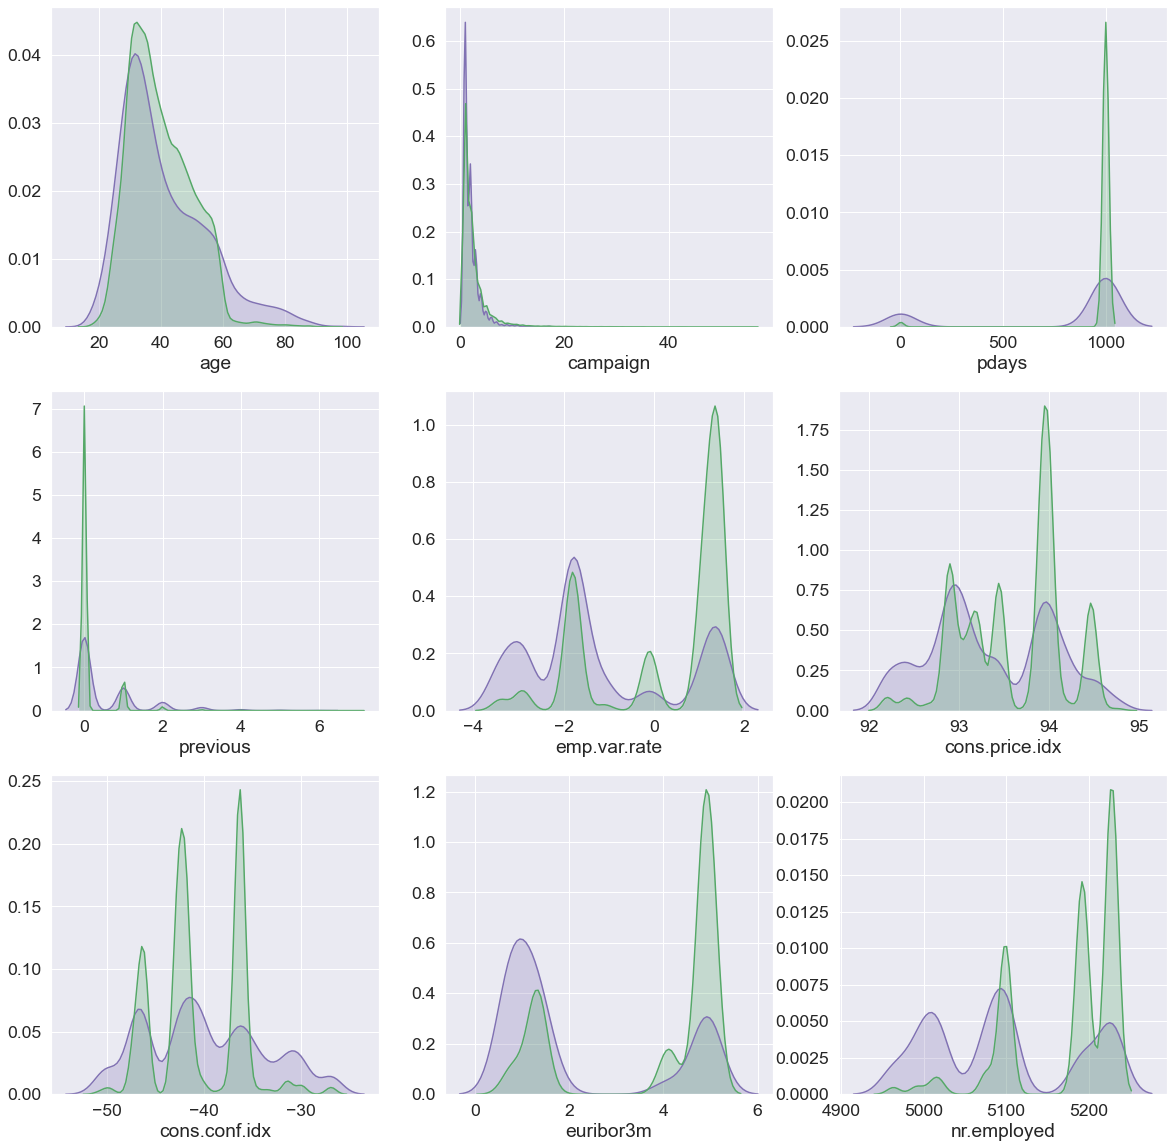

In [54]:
df_num = df.select_dtypes(exclude='object')
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
idx = 0

for i in range(0, 3):
    for j in range(0, 3):
        sns.distplot(df_num.iloc[:, idx][df.y == 'yes'], hist=False, kde_kws={"shade": True}, ax=axes[i, j], color='m')
        sns.distplot(df_num.iloc[:, idx][df.y == 'no'], hist=False, kde_kws={"shade": True}, ax=axes[i, j], color='g')
        idx += 1

## Correlation Heatmap

This section visually inspects correlation between numeric features. Strong correlation will violate assumption of some models such as linear regression.

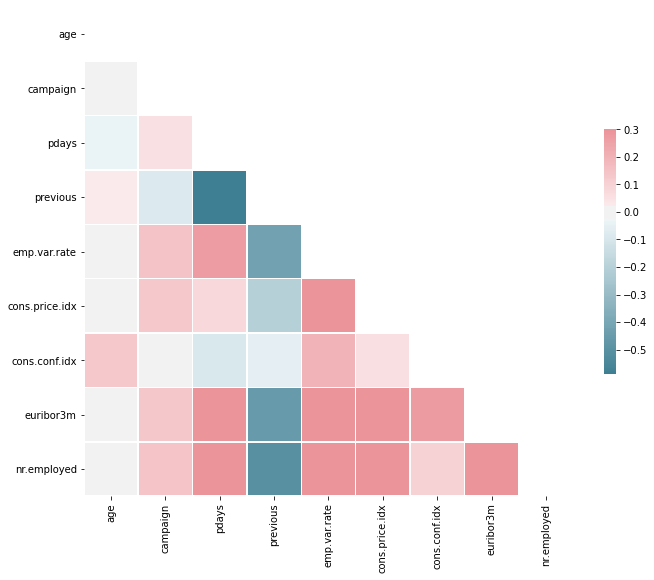

In [14]:
mask = np.triu(np.ones_like(df_num.corr(), dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_num.corr(), mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5});

## Feature Importance by Random Forest and Gradient Boosting

This section we let models tell us what features are important.

Taking top five features from each model, here's the result:
Age, euribor3m, campaign, pdays, nr.employed, and cons.conf.idx.

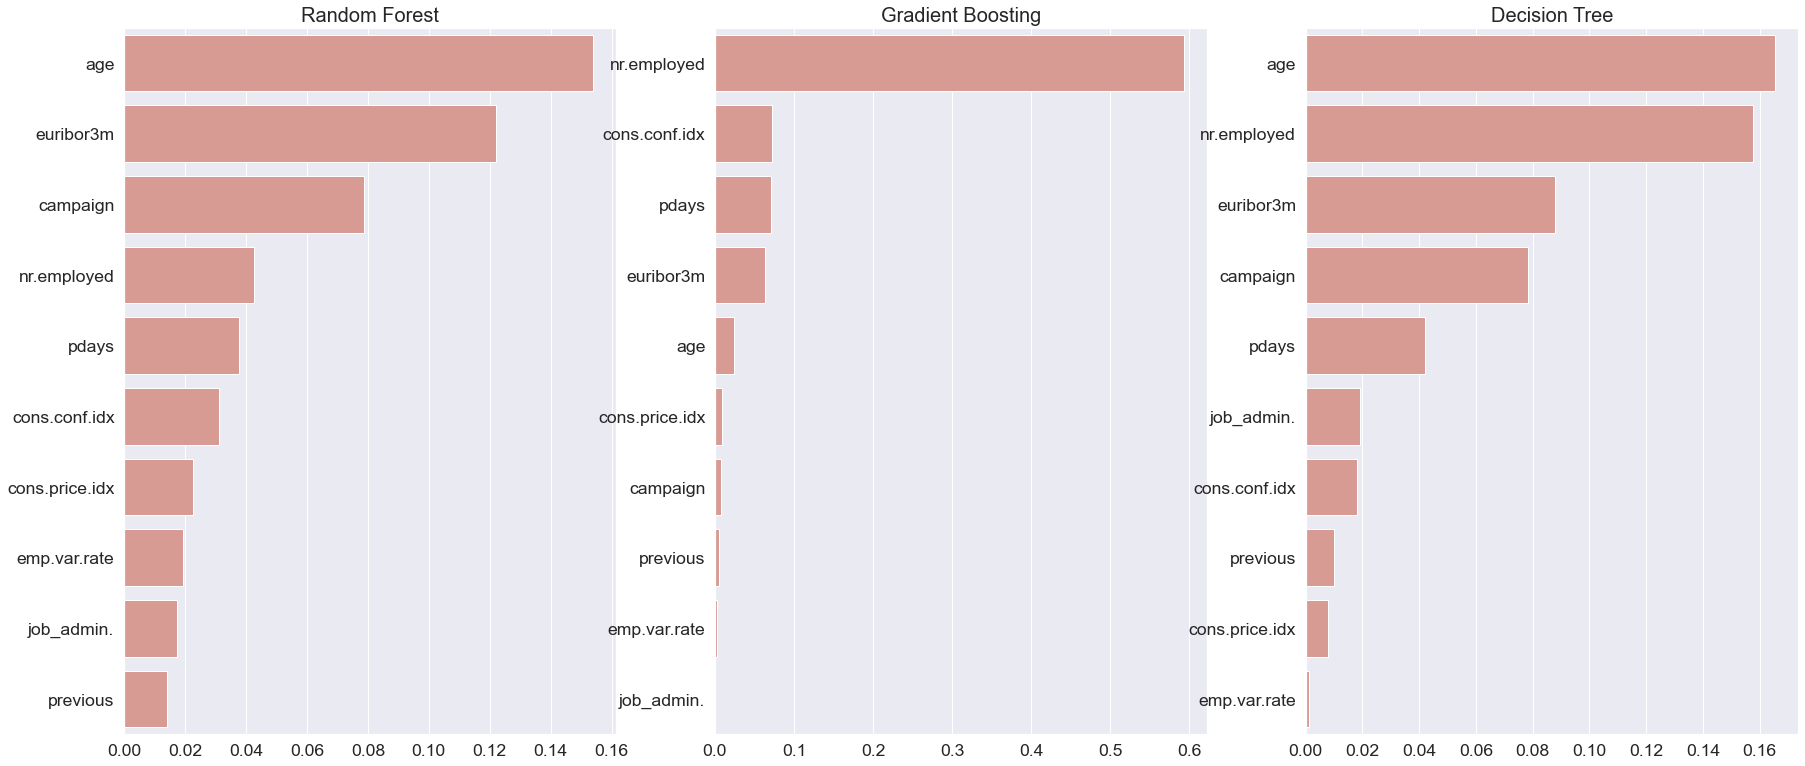

In [53]:
def featureImp(model, trainSet, top_n=10, ax=0):
    feature_imp = pd.Series(data=model.feature_importances_, index=trainSet.columns)[:top_n].sort_values(ascending=False)
    sns.barplot(feature_imp.values, feature_imp.index, ax=ax, color='salmon', saturation=0.5)
    
def permutationImp(model, X_test, y_test):
    perm = PermutationImportance(model, random_state=seed).fit(X_test, y_test)
    return eli5.show_weights(perm, feature_names=X_test.columns.tolist())

sns.set(font_scale=1.6)
fig, axes = plt.subplots(1, 3, figsize=(30, 13))
featureImp(rf_model, X_train, ax=axes[0])
featureImp(gb_model, X_train, ax=axes[1])
featureImp(tree_model, X_train, ax=axes[2])
axes[0].set_title('Random Forest', fontsize=20)
axes[1].set_title('Gradient Boosting', fontsize=20)
axes[2].set_title('Decision Tree', fontsize=20);

## Permutation Importance by Random Forest

Taking top five from each model, here's the result:
pdays, month_oct, month_apr, poutcome_failure, poutcome_success, nr.employed, euribor3m, emp.var.rate, and cons.price.idx.

month_oct and month_apr are pretty interesting... Maybe part of the consumers that this bank is targeting are seasonal workers so that their income are high in these 2 months?

In [53]:
permutationImp(rf_model, X_test, y_test)

Weight,Feature
0.0025 ± 0.0006,pdays
0.0008 ± 0.0003,month_oct
0.0005 ± 0.0002,month_apr
0.0004 ± 0.0007,poutcome_failure
0.0002 ± 0.0004,poutcome_success
0.0000 ± 0.0004,job_self-employed
0.0000 ± 0.0001,job_unknown
0 ± 0.0000,default_yes
0 ± 0.0000,education_illiterate
-0.0000 ± 0.0001,marital_unknown


## Permutation Importance by Gradient Boosting

In [54]:
permutationImp(gb_model, X_test, y_test)

Weight,Feature
0.0104 ± 0.0005,nr.employed
0.0078 ± 0.0012,month_oct
0.0028 ± 0.0009,euribor3m
0.0027 ± 0.0014,pdays
0.0014 ± 0.0005,poutcome_success
0.0012 ± 0.0003,campaign
0.0011 ± 0.0005,poutcome_failure
0.0010 ± 0.0010,day_of_week_mon
0.0006 ± 0.0005,contact_telephone
0.0005 ± 0.0002,job_student


## Permutation Importance by Logistic Regression

In [55]:
permutationImp(logit_model, X_test, y_test)

Weight,Feature
0.0129 ± 0.0019,pdays
0.0079 ± 0.0016,nr.employed
0.0022 ± 0.0006,euribor3m
0.0019 ± 0.0017,emp.var.rate
0.0017 ± 0.0012,cons.price.idx
0.0009 ± 0.0007,month_may
0.0008 ± 0.0006,contact_cellular
0.0007 ± 0.0010,contact_telephone
0.0006 ± 0.0005,education_university.degree
0.0005 ± 0.0003,campaign
